##### Copyright 2021 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title License information
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.



# _Diversity and Inclusion Metrics in Subset Selection_ Demo



The following notebook is an example implementation of a very simple way one might define and implement diversity and inclusion scoring for images of people.

This is based on the paper [_Diversity and Inclusion Metrics in Subset Selection_](https://arxiv.org/pdf/2002.03256.pdf) and has a corresponding [PAIR explorable](https://pair.withgoogle.com/explorables/measuring-diversity/).

Written by Dylan Baker.

In [ ]:
#@title Imports

import numpy as np
from collections import defaultdict
import functools
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import attr
import random
from IPython.display import Image as ipython_image
from IPython.display import HTML
from six.moves import reload_module

In [ ]:
#@title Utility functions

"""Utils for Diversity and Inclusion metrics colab notebook."""

import abc
import six


class Entity(object):
  """An entity for scoring using diversity and inclusion metrics.

  Entities have properties, which are the axes along which diversity and
  inclusion are scored.
  """

  def __init__(self, properties, title=''):
    self.properties = properties
    self._title = title

  def __repr__(self):
    return self._title + ' '.join(
        ['%s: %s' % (key, value) for key, value in self.properties.items()])


class EntityImage(object):
  """An image of an entity.

  An image can have properties that are separate from the properties of the
  entities.
  """

  def __init__(self, entities, image_fetcher, properties=None):
    self.entities = entities
    self.properties = properties
    self._image_fetcher = image_fetcher

  def show(self):
    self._image_fetcher.fetch()


@six.add_metaclass(abc.ABCMeta)
class ImageFetcher(object):
  """Fetches an image of an entity for display."""

  @abc.abstractmethod
  def __init__(self):
    """Initialize ImageFetcher with input parameters."""
    pass

  @abc.abstractmethod
  def fetch(self):
    """Fetch and display the image itself."""
    pass


In [ ]:
#@title Enums

# Lint as: python3
"""Enums to be used in a demo colab notebook implementing D&I metrics."""
import enum


def get_enum_values(enum_class):
  """Helper function to get all possible values of an Enum.

  Args:
    enum_class: A class that inherits from enum.Enum

  Returns:
    Set containing all enum values in input class.
  """
  return set(
      [enum_value for _, enum_value in list(enum_class.__members__.items())])


class SkinType(enum.Enum):
  UNKNOWN = 0
  TYPE_1 = 1
  TYPE_2 = 2
  TYPE_3 = 3
  TYPE_4 = 4
  TYPE_5 = 5
  TYPE_6 = 6


# Choosing presentation over gender to better line up with infering
# this from photos.
class GenderPresentation(enum.Enum):
  UNKNOWN = 0
  FEMININE = 1
  MASCULINE = 2
  # Intended to be a very broad umbrella.
  ANDROGYNOUS = 3


# Using wide buckets because it's very hard to infer from photos.
class Age(enum.Enum):
  UNKNOWN = 0
  RANGE_0_17 = 1
  RANGE_18_24 = 2
  RANGE_25_44 = 3
  RANGE_45_64 = 4
  RANGE_65_OVER = 5


class Color(enum.Enum):
  RED = 1
  BLUE = 2
  GREEN = 3


class Size(enum.Enum):
  SMALL = 1
  MEDIUM = 2
  LARGE = 3


class ShapeType(enum.Enum):
  TRIANGLE = 1
  SQUARE = 2
  CIRCLE = 3


def age_to_enum(age):
  """Parses age integer into Age enum class."""
  if age <= 17:
    return Age.RANGE_0_17
  elif age <= 24:
    return Age.RANGE_18_24
  elif age <= 44:
    return Age.RANGE_25_44
  elif age <= 64:
    return Age.RANGE_45_64
  elif age >= 65:
    return Age.RANGE_65_OVER
  else:
    raise ValueError('Unable to parse age: ', age)


def gender_to_enum(gender):
  """Parses string to GenderPresentation enum."""
  if gender.lower() == 'masculine':
    return GenderPresentation.MASCULINE
  elif gender.lower() == 'feminine':
    return GenderPresentation.FEMININE
  elif gender.lower() == 'androgynous':
    return GenderPresentation.ANDROGYNOUS
  else:
    raise ValueError('Unable to parse gender: ', gender)


def skin_type_to_enum(skin_type):
  """Parses string to SkinType enum."""
  return SkinType(skin_type)

In [ ]:
#@title Display

"""Display functions for Diversity & Inclusion Metrics Explorable Colab."""

import random

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

# Default canvas size for drawing shape images.
_DEFAULT_HEIGHT, _DEFAULT_WIDTH = 150, 250

# Map Sizes to the edge size of a tight square bounding box around a shape.
_SIZE_TO_WIDTH = {
    Size.SMALL: _DEFAULT_WIDTH / 10,
    Size.MEDIUM: _DEFAULT_WIDTH / 5,
    Size.LARGE: _DEFAULT_WIDTH / 3
}

# Padding around canvas edge to avoid too much spillover off of the canvas.
_BORDER = _DEFAULT_WIDTH / 10

# Map the color enums to some nicer matplotlib colors.
_COLOR_TO_MATPLOTLIB = {
    Color.RED: 'firebrick',
    Color.BLUE: 'skyblue',
    Color.GREEN: 'forestgreen',
}


def _get_bbox(center, size):
  """Get a bounding box for a shape given a center point and a Size."""
  center_x, center_y = center
  shape_edge_size = _SIZE_TO_WIDTH[size]
  left = int(center_x - 0.5 * shape_edge_size)
  right = int(center_x + 0.5 * shape_edge_size)
  top = int(center_y - 0.5 * shape_edge_size)
  bottom = int(center_y + 0.5 * shape_edge_size)
  return left, right, bottom, top


def _get_random_center():
  return (random.randint(_BORDER, _DEFAULT_WIDTH - _BORDER),
          random.randint(_BORDER, _DEFAULT_HEIGHT - _BORDER))


def _draw_triangle(draw,
                   size=Size.SMALL,
                   color=Color.BLUE,
                   center=None):
  if not center:
    center = _get_random_center()
  left, right, bottom, top = _get_bbox(center, size)
  center_x, unused_center_y = center
  draw.polygon([(left, bottom), (center_x, top), (right, bottom)],
               fill=color,
               outline='black')


def _draw_square(draw,
                 size=Size.SMALL,
                 color=Color.BLUE,
                 center=None):
  if not center:
    center = _get_random_center()
  left, right, bottom, top = _get_bbox(center, size)
  draw.rectangle([(left, top), (right, bottom)],
                 fill=color,
                 outline='black',
                 width=1)


def _draw_circle(draw,
                 size=Size.SMALL,
                 color=Color.BLUE,
                 center=None):
  if not center:
    center = _get_random_center()
  left, right, bottom, top = _get_bbox(center, size)
  draw.ellipse([(left, top), (right, bottom)],
               fill=color,
               outline='black',
               width=1)


def _draw_one_shape(draw, shape, center):
  """Draws the given shape with a given center point.

  Args:
    draw: ImageDraw.Draw object.
    shape: The input shape entity.
    center: (x,y) center coordinates.
  """
  if shape.properties[ShapeType] == ShapeType.TRIANGLE:
    _draw_triangle(
        draw,
        shape.properties[Size],
        _COLOR_TO_MATPLOTLIB[shape.properties[Color]],
        center=center)
  if shape.properties[ShapeType] == ShapeType.SQUARE:
    _draw_square(
        draw,
        shape.properties[Size],
        _COLOR_TO_MATPLOTLIB[shape.properties[Color]],
        center=center)
  if shape.properties[ShapeType] == ShapeType.CIRCLE:
    _draw_circle(
        draw,
        shape.properties[Size],
        _COLOR_TO_MATPLOTLIB[shape.properties[Color]],
        center=center)


def _show_image_html_from_url(img_url, max_width=200):
  """Show an image inline from a URL using colabtools HTML."""
  img_html = '<img src="{0}" width={1}>'.format(img_url, max_width)
  display(HTML(img_html))



class PersonFetcher(ImageFetcher):
  """A Fetcher for displaying an image loaded from a URL."""

  def __init__(self, image_url):
    self._image_url = image_url

  def fetch(self):
    _show_image_html_from_url(self._image_url)


class ShapeFetcher(ImageFetcher):
  """A Fetcher for displaying shapes drawn with matplotlib."""

  def __init__(self, shapes, title=None, shuffle=True):
    self._shapes = shapes
    self._title = title
    self._shuffle_shapes_when_displaying = shuffle

  def fetch(self):
    draw_shapes(
        self._shapes,
        title=self._title,
        shuffle=self._shuffle_shapes_when_displaying)


def create_image_from_shapes(shapes, title=''):
  """Returns an EntityImage from a list of input shapes.

  This is initialized with a ShapeFetcher, which is used to draw the image.

  Args:
    shapes: List of shape Entities.
    title: An optional title for the image, for display.

  Returns:
    Initialized EntityImage.
  """
  return EntityImage(shapes, ShapeFetcher(shapes, title))


def draw_shapes(shapes, title=None, shuffle=True):
  """Draws shape entities on a new matplotlib plot.

  Example usage:

    my_shapes = [
      Entity(properties = {
        Color: Color.BLUE,
        Size: Size.LARGE,
        ShapeType: ShapeType.CIRCLE,
      })
    ]

    draw_shapes(my_shapes, 'A large blue circle')

  Args:
    shapes: List of input shape Entities. Each entity must have Color, Size, and
      ShapeType specified as properties.
    title: A title, to be shown at the top of the image.
    shuffle: Whether or not to shuffle the order of the shapes when drawing.
  """
  canvas = Image.fromarray(np.ones([_DEFAULT_HEIGHT, _DEFAULT_WIDTH]) *
                           240).convert('RGBA')
  draw = ImageDraw.Draw(canvas)
  center_x_coords = np.linspace(_BORDER, _DEFAULT_WIDTH - _BORDER,
                                len(shapes) + 2)[1:-1]

  # Alternate upper and lower coordinates; this spaces out the shapes more
  # nicely.
  center_y_values = np.linspace(_BORDER, _DEFAULT_HEIGHT - _BORDER, 4)[1:-1]
  center_y_coords = [center_y_values[i % 2] for i in range(len(shapes))]
  centers = zip(center_x_coords, center_y_coords)
  if shuffle:
    random.shuffle(shapes)
  for shape, center in zip(shapes, centers):
    _draw_one_shape(draw, shape, center)

  if title:
    draw.text((10, 10), title, (0, 0, 0))

  plt.imshow(canvas, aspect='equal')
  plt.axis('off')
  plt.grid(False)
  plt.show()

In [ ]:
#@title Scoring

"""Scoring functions for diversity and inclusion demo."""

import numpy as np
import collections

# Using strings here so we're able to easily check for membership in each set;
# EnumMeta doesn't support comparison.
# These are properties where closer enum values correspond to actual similarity.
_CLOSENESS_PROPERTIES = frozenset(
    [str(Age), str(SkinType),
     str(Size)])
# These are properties where enum values are independent.
_MATCH_PROPERTIES = frozenset(
    [str(GenderPresentation),
     str(Color),
     str(ShapeType)])


def _to_aggregator_fn(aggregator):
  """Maps from name to aggregator function.

  Args:
    aggregator: Either a name (e.g. 'average'), or for the weighted average
      case, a dictionary mapping category names (e.g. Color) to weights
      (e.g. 0.4).

  Returns:
    A function that takes a {category name, value} dictionary and returns a
      float.
  """

  # If this is a dict, we're using it to compute weighted averages.
  def compute_weighted_average(weights_dict):
    return sum([value * aggregator[key] for key, value in weights_dict.items()])

  if isinstance(aggregator, dict):
    return compute_weighted_average

  score_fn = None
  if aggregator == 'average':
    score_fn = np.average
  elif aggregator == 'min':
    score_fn = min
  elif aggregator == 'max':
    score_fn = max
  elif aggregator == 'nash':
    score_fn = nash_score
  elif aggregator == 'utilitarian':
    score_fn = utilitarian_score
  elif aggregator == 'egalitarian':
    score_fn = egalitarian_score
  else:
    raise NotImplementedError('Aggregation method %s not implemented' %
                              aggregator)

  # Just return a function that scores each value in the input score dict.
  return (lambda score_dict: score_fn(
      [value for unused_key, value in score_dict.items()]))


def nash_score(subscores):
  """Compute Nash inclusivity score."""
  root = len(subscores)
  return np.prod(subscores)**(1 / root)


def utilitarian_score(subscores):
  """Compute Utilitarian inclusivity score."""
  return sum(subscores) / len(subscores)


def egalitarian_score(subscores):
  """Compute Egalitarian (maximin) inclusivity score."""
  return min(subscores)


# We have a separate comparison function here because we need
# all of the subscores for tiebreaking.
def egalitarian_compare(subscores_a, subscores_b):
  """Returns 1 if subscores_a > subscores_b, 0 if they are equal, -1 otherwise."""
  if len(subscores_a) != len(subscores_b):
    raise ValueError('Subscores must have the same length.')
  print(subscores_a, subscores_b)
  subscores_a.sort()
  subscores_b.sort()
  print(subscores_a, subscores_b)
  for first_a, first_b in zip(subscores_a, subscores_b):
    if first_a == first_b:
      continue
    else:
      return 1 if first_a > first_b else -1
  # Return 0 if they're the same.
  return 0


class Scorer(object):
  """An object that scores and ranks images or sets of images.

  Scoring is dependent on the person making a query and the query they made.
  """

  def __init__(self,
               viewer,
               diversity_fn=None,
               inclusion_fn=None,
               combiner=None):
    """Initializes a scorer.

    Args:
      viewer: A Viewer to serve as a reference point when scoring results.
      diversity_fn: A DiversityFn, which calculates per-image diversity scores.
      inclusion_fn: An InclusionFn, which calculates per-image inclusion scores.
      combiner: A Combiner, which combines inclusion and diversity scores.
    """
    self.viewer = viewer
    self.diversity_fn = diversity_fn
    self.inclusion_fn = inclusion_fn
    self.combiner = combiner

  def get_image_subscores(self, image, query='', verbose_output=False):
    """Computes diversity and inclusion subscores for a single image.

    Args:
      image: An EntityImage
      query: The query, used for computing relevance inclusion subscore.
      verbose_output: Whether or not to print out all computation steps.

    Returns:
      Dictionaries mapping diversity and inclusion subscore names to values.
    """
    if not self.diversity_fn or not self.inclusion_fn or not self.combiner:
      raise ValueError('Diversity, inclusion, and combination functions '
                       'must all be specified. (%s, %s, %s)' %
                       (self.diversity_fn, self.inclusion_fn, self.combiner))
    if verbose_output:
      print('\n===================')
      print('===== Scoring =====')
      print('===================\n')
      image.show()
      print(self.viewer)
      if query:
        print('Query:', query)
    diversity_scores = self.diversity_fn.score_image(
        image, verbose_output=verbose_output)
    inclusion_scores = self.inclusion_fn.score_image(
        viewer=self.viewer,
        image=image,
        query=query,
        verbose_output=verbose_output)
    return diversity_scores, inclusion_scores

  def score_image(self, image, query='', verbose_output=False):
    """Computes diversity and inclusion scores for a single image.

    Args:
      image: An EntityImage
      query: The query, used for computing relevance inclusion subscore.
      verbose_output: Whether or not to print out all computation steps.

    Returns:
      A single net score for the image, float.
    """
    diversity_scores, inclusion_scores = self.get_image_subscores(
        image, query=query, verbose_output=verbose_output)

    net_score = self.combiner.combine(
        diversity_scores=diversity_scores,
        inclusion_scores=inclusion_scores,
        aggregation_level='image',
        verbose_output=verbose_output)

    return net_score

  def rank_images(self, images, query='', verbose_output=False):
    """Rank a list of images using their net diversity and inclusion scores.

    Args:
      images: A list of EntityImages.
      query: The query, used for computing relevance inclusion subscore.
      verbose_output: Whether or not to print out final ranking.

    Returns:
      A sorted list of (image, score) tuples.
    """
    # In this case, verbose_output refers to whether or not you will print out
    # the ranking itself.
    if self.combiner.diversity_aggregate_name == 'egalitarian':
      # True egalitarian ranking would give us separate diversity & inclusion
      # rankings.
      logging.warn('Warning: egalitarian tiebreaking not implemented.')

    # Don't use verbose_output for the scoring itself, only for the ranking.
    images_with_scores = [(image,
                           self.score_image(image, query, verbose_output=False))
                          for image in images]
    images_with_scores.sort(key=lambda x: x[1], reverse=True)
    if verbose_output:
      print('===================')
      print('===== Ranking =====')
      print('===================')
      print(self.viewer)
      print('Query: %s' % query)
      print('\n')
      for index, (image, score) in enumerate(images_with_scores):
        print('==== Ranking %d [score: %s] ====' %
              (index + 1, np.around(score, 3)))
        image.show()
        print('\n')
    return images_with_scores

  def get_set_subscores(self, images, query='', verbose_output=False):
    """Score a set of images."""

    # Dictionaries mapping image names to their diversity/inclusion scores.
    diversity_per_image_subscores, inclusion_per_image_subscores = {}, {}

    for index, image in enumerate(images):
      image_name = 'image %d' % (index + 1)
      if verbose_output:
        print('\nScoring %s\n' % image_name)
      diversity_subscore, inclusion_subscore = self.get_image_subscores(
          image, query=query, verbose_output=verbose_output)

      # Aggregate across entities in each image to get the net
      # diversity/inclusion score for that image.
      diversity_per_image_subscores[
          image_name] = self.combiner.aggregate_diversity_scores(
              diversity_subscore)
      inclusion_per_image_subscores[
          image_name] = self.combiner.aggregate_inclusion_scores(
              inclusion_subscore)

    return diversity_per_image_subscores, inclusion_per_image_subscores

  def score_set(self, images, query='', verbose_output=False):
    """Score a set of images.

    Args:
      images: A list of EntityImages.
      query: The query, used for computing relevance inclusion subscore.
      verbose_output: Whether or not to print out all computation steps.

    Returns:
      A single net score for the image set, float.
    """
    diversity_per_image_subscores, inclusion_per_image_subscores = self.get_set_subscores(
        images=images, query=query, verbose_output=verbose_output)
    net_score = self.combiner.combine(
        diversity_scores=diversity_per_image_subscores,
        inclusion_scores=inclusion_per_image_subscores,
        aggregation_level='set',
        verbose_output=verbose_output)

    return net_score


class Combiner(object):
  """An object that combines diversity and inclusion scores.

  This applies to both individual images and sets of images.
  """

  def __init__(self,
               diversity_weight=0.5,
               inclusion_weight=None,
               diversity_aggregate='average',
               inclusion_aggregate='average',
               set_diversity_aggregate='average',
               set_inclusion_aggregate='average'):
    """Initializes Combiner.

    A Combiner combines all of the diversity and inclusion subscores using
    aggregator functions specified in the constructor.

    Args:
      diversity_weight: In computing a final score, amount to weight the net
        diversity score vs. inclusion score.
      inclusion_weight: In computing a final score, amount to weight the net
        inclusion score vs. diversity score.
      diversity_aggregate: How to aggregate diversity subscores across entities
        within one image. Can either be a string indicating a type to apply for
        all subscores (e.g. 'average') or a function that computes the average.
      inclusion_aggregate:  How to aggregate inclusion subscores across entities
        within one image. Can either be a string indicating a type to apply for
        all subscores (e.g. 'average') or a function that computes the average.
      set_diversity_aggregate: How to aggregate diversity subscores across
        images in a set.
      set_inclusion_aggregate: How to aggregate inclusion subscores across
        images in a set.
    """
    self.diversity_weight = diversity_weight
    self.inclusion_weight = inclusion_weight

    # Normalize diversity_weight and inclusion_weight to sum to 1.
    self._normalize_weights()

    self.diversity_aggregate_name = (
        diversity_aggregate
        if isinstance(diversity_aggregate, str) else 'weighed_average')
    self.inclusion_aggregate_name = (
        inclusion_aggregate
        if isinstance(inclusion_aggregate, str) else 'weighed_average')
    self.set_diversity_aggregate_name = (
        set_diversity_aggregate
        if isinstance(set_diversity_aggregate, str) else 'weighed_average')
    self.set_inclusion_aggregate_name = (
        set_inclusion_aggregate
        if isinstance(set_inclusion_aggregate, str) else 'weighed_average')

    self._diversity_agg_fn = _to_aggregator_fn(diversity_aggregate)
    self._inclusion_agg_fn = _to_aggregator_fn(inclusion_aggregate)
    self._set_diversity_agg_fn = _to_aggregator_fn(set_diversity_aggregate)
    self._set_inclusion_agg_fn = _to_aggregator_fn(set_inclusion_aggregate)

  def combine(self, diversity_scores, inclusion_scores, aggregation_level,
              verbose_output):
    """Combines raw diversity and inclusion scores for an image or image set.

    More specifically, this aggregates diversity and inclusion scores from an
    input image and computes a weighted average of those aggregates.

    The method for computing these aggregates, as well as the relative weights
    for diversity and inclusion scores, are set when we construct a Combiner.

    Args:
      diversity_scores: Dictionary mapping diversity subscore names to values.
      inclusion_scores: Dictionary mapping inclusion subscore names to values.
      aggregation_level: What we are combining across, either 'image' or 'set'.
      verbose_output: Whether or not to log all of the computation steps.

    Returns:
      A single aggregated score for the image or image set, float.
    """

    # Normalize weights so they sum to 1.
    self._normalize_weights()

    # Aggregate per-attribute diversity subscores into per-image scores.
    image_diversity_score = self.aggregate_scores(
        diversity_scores,
        diversity_or_inclusion='diversity',
        aggregation_level=aggregation_level,
        verbose_output=verbose_output)
    # Aggregate per-attribute inclusion subscores into per-image scores.
    image_inclusion_score = self.aggregate_scores(
        inclusion_scores,
        diversity_or_inclusion='inclusion',
        aggregation_level=aggregation_level,
        verbose_output=verbose_output)
    # Calculate the actual weighted average.
    score = ((self.diversity_weight * image_diversity_score) +
             (self.inclusion_weight * image_inclusion_score))

    if verbose_output:
      print()
      print('Combining diversity and inclusion scores at the %s level:' %
            aggregation_level)
      print('     %s * %s +' %
            (self.diversity_weight, np.around(image_diversity_score, 3)))
      print('     %s * %s =\n' %
            (self.inclusion_weight, np.around(image_inclusion_score, 3)))

      print('     -------------------')
      print('    | Final score:  %s |' % np.around(score, 3))
      print('     -------------------')

    return score

  def _get_aggregator_and_name(self, diversity_or_inclusion, aggregation_level):
    """Returns specified aggregation function function and name."""

    if diversity_or_inclusion == 'diversity':
      if aggregation_level == 'set':
        return self.set_diversity_aggregate_name, self._set_diversity_agg_fn
      elif aggregation_level == 'image':
        return self.diversity_aggregate_name, self._diversity_agg_fn

    elif diversity_or_inclusion == 'inclusion':
      if aggregation_level == 'set':
        return self.set_inclusion_aggregate_name, self._set_inclusion_agg_fn
      elif aggregation_level == 'image':
        return self.inclusion_aggregate_name, self._inclusion_agg_fn

    raise ValueError('No aggregator specified for %s, %s' %
                     (diversity_or_inclusion, aggregation_level))

  def aggregate_scores(self,
                       scores,
                       diversity_or_inclusion=None,
                       aggregation_level=None,
                       verbose_output=False):
    """Aggregate all scores using aggretation fn.

    Args:
      scores: Dictionary mapping subscore name to subscore value.
      diversity_or_inclusion: Which score you're aggregating (e.g. 'diversity').
      aggregation_level: Level at which you're aggregating (e.g. 'set', 'image')
      verbose_output: Whether or not to log all of the computation steps.

    Returns:
      Aggregated score, float.
    """

    aggregation_fn_name, aggregation_fn = self._get_aggregator_and_name(
        diversity_or_inclusion, aggregation_level)

    total = aggregation_fn(scores)
    if verbose_output:
      print()
      print('Aggregating %s-level %s scores with method: %s' %
            (aggregation_level, diversity_or_inclusion, aggregation_fn_name))
      print('--> Net %s-level %s score: %s' %
            (aggregation_level, diversity_or_inclusion, np.around(total, 3)))
    return total

  def aggregate_diversity_scores(self, diversity_scores, verbose_output=False):
    return self.aggregate_scores(
        diversity_scores,
        diversity_or_inclusion='diversity',
        aggregation_level='image',
        verbose_output=verbose_output)

  def aggregate_inclusion_scores(self, inclusion_scores, verbose_output=False):
    return self.aggregate_scores(
        inclusion_scores,
        diversity_or_inclusion='inclusion',
        aggregation_level='image',
        verbose_output=verbose_output)

  def _normalize_weights(self):
    if not self.inclusion_weight:
      if (self.diversity_weight < 0.0 or self.diversity_weight > 1.0):
        raise ValueError(
            'Weights should be between 0 and 1 if only one is specified')
      self.inclusion_weight = np.around(1.0 - self.diversity_weight, 3)
    else:
      total = sum([self.diversity_weight, self.inclusion_weight])
      self.diversity_weight = self.diversity_weight / total
      self.inclusion_weight = self.inclusion_weight / total


def _to_integer_boolean(input_dict):
  """Replaces each value in a dict with a 1 if it is truthy, 0 otherwise.

  This is useful for converting counts to simple presence/absence of a property.

  Args:
    input_dict: An arbitrary dictionary.

  Returns:
    A dictionary mapping each input key to either 1 or 0.
  """
  return {key: int(bool(value)) for key, value in input_dict.items()}


class DiversityFn(object):
  """A function that computes diversity subscores for an EntityImage."""

  def __init__(self,
               aggregate_method='average',
               count_or_binary='binary',
               verbose_output=False):
    self.aggregate_method = aggregate_method

    # Whether or not to take into account the number of instances of a property
    # or simply take into account whether or not the property was present at
    # all.
    self.count_or_binary = count_or_binary
    self._agg_fn = _to_aggregator_fn(aggregate_method)
    self._verbose_output = verbose_output

  def score_image(self, image, verbose_output=None):
    """Computes all diversity subscores for an image.

    Args:
      image: An EntityImage.
      verbose_output: Whether or not to print out computation steps.

    Returns:
      Dictionary mapping subscore names to values.
    """
    # Allow overriding default verbosity
    if verbose_output is not None:
      self._verbose_output = verbose_output

    if self._verbose_output:
      print('\n===================================')
      print('Diversity subscores (single image):')
      print('===================================\n')
      print('  - Aggregating scores across entities in image using method: %s' %
            self.aggregate_method)
      print('  - Using counts or simple binary presence/absence? %s' %
            self.count_or_binary)

    scores = self._get_scores(image)

    if self._verbose_output:
      if len(image.entities) == 1:
        print('Note: this image contains a single entity, so diversity is '
              'low by definition.')
    return scores

  def _get_scores(self, image):
    """Gets property-level scores for a single image.

    Args:
      image: An EntityImage containing one or more Entities

    Returns:
      Dictionary mapping subscore names to values.
    """
    output_string = ''

    # Compute presence vectors as well as a dictionary mapping the property
    # to a debug string, constructed when vector was being computed. This stores
    # the specific enum value counts (e.g. Color.BLUE : 2), which are not
    # preserved in the presence vectors (e.g. [0, 2, 0]) themselves.
    presence_vectors, presence_string_dict = self._get_presence_vectors(image)

    # Filter into a dictionary with 1s if property was present and 0s otherwise.
    if self.count_or_binary == 'binary':
      presence_vectors = {
          key: _to_integer_boolean(value)
          for key, value in presence_vectors.items()
      }

    # Aggregate the per-enum-category vectors.
    aggregated = {
        key: self._agg_fn(presence_vector)
        for key, presence_vector in presence_vectors.items()
    }

    # Generate output string for verbose output.
    for key, agg_score in aggregated.items():
      # String generated when we were calculating presence/absences scores
      presence_string = presence_string_dict[key]
      output_string += '\n   Which of the possible %ss are present?' % key
      output_string += '\n   --> %s subscore: %s' % (key, np.round(
          agg_score, 3))
      output_string += presence_string
      if self.count_or_binary == 'binary':
        if self.aggregate_method == 'average':
          output_string += ('\n           %s %ss represented / %s total '
                            'categories') % (
                                str(sum(presence_vectors[key].values())), key,
                                str(len(presence_vectors[key].values())))
        output_string += '\n           %s (binary vector): %s\n' % (
            self.aggregate_method, np.round(agg_score, 3))
      else:
        output_string += '\n           %s: %s\n' % (self.aggregate_method,
                                                    np.round(agg_score, 3))

    if self._verbose_output:
      print(output_string)

    return aggregated

  def _get_presence_vectors(self, image):
    """Gets vectors indicating presence/absence of properties in an image.

    Args:
      image: An EntityImage.

    Returns:
      A nested dictionary, where they keys are property names
      (e.g. age) and the values are dictionaries mapping all values of that
      property (e.g. Age.RANGE_18_24) to the number of entities with that
      property in each image.
    """

    output_string_dict = dict()

    # Establish a set of all properties _any_ entities has, as well
    # as all possible values for that enum. E.g. if any entity has property
    # 'age', all_properties should contain the mapping:
    # { 'age' : {<Age.UNKNOWN: 0>, <Age.RANGE_18_24: 2> ...} }
    all_properties = dict()

    # Dict mapping property name to all properties present in the image.
    present_properties = collections.defaultdict(list)

    for person in image.entities:
      for name, value in person.properties.items():
        # Overwrite each time, these are small and it's convenient.
        all_properties[name] = get_enum_values(type(value))
        present_properties[name].append(value)

    # Count occurrences of each value for each property.
    to_return = {}
    for property_name, all_enum_values in all_properties.items():
      output_string_dict[property_name] = ''
      presences = {}
      for enum_value in all_enum_values:
        output_string_dict[property_name] += '\n           %s: %s' % (
            enum_value, present_properties[property_name].count(enum_value))
        presences[enum_value] = present_properties[property_name].count(
            enum_value)
      to_return[property_name] = presences

    return to_return, output_string_dict


class InclusionFn(object):
  """A function that computes inclusion subscores for an EntityImage."""

  def __init__(self, aggregate_method='max', verbose_output=False):
    """Initializes InclusionFn.

    Args:
      aggregate_method: Method of combining scores of entities within an image.
      verbose_output: Whether or not to log all of the computation steps.

    Returns:
      Initialized InclusionFn.
    """
    self.aggregate_method = aggregate_method
    self._agg_fn = _to_aggregator_fn(aggregate_method)
    self._verbose_output = verbose_output
    assert _CLOSENESS_PROPERTIES is not None
    assert _MATCH_PROPERTIES is not None

  def score_image(self, viewer, image, query='', verbose_output=None):
    """Scores an input image.

    Args:
      viewer: An Entity representing the entity making a query.
      image: An EntityImage.
      query: A viewer's query related to the EntityImage.
      verbose_output: Whether or not to print out computation steps.

    Returns:
      A dictionary mapping inclusion subscore names to values.
    """

    # TODO(dylanbaker): Implement query relevance scoring. At minimum, this
    # requires EntityImages or Entities having some way of denoting their
    # subject.
    # logging.warning('Query %s is unused', query)

    # Allow verbose_output to be overridden here; otherwise, defualt
    # to initial state.
    if verbose_output is None:
      verbose_output = self._verbose_output
    if verbose_output:
      print('\n===================================')
      print('Inclusion subscores (single image)')
      print('===================================\n')
      print('  - Using aggregation method: %s\n' % self.aggregate_method)

    subscores = {}
    if not image.entities:
      logging.warning('No entities to score.')
      return {}

    all_property_names = [
        type(value) for value in list(image.entities[0].properties.values())
    ]

    for property_name in all_property_names:
      if str(property_name) in _CLOSENESS_PROPERTIES:
        subscores[property_name] = self._compute_closeness(
            viewer, image, property_name, verbose_output)
      elif str(property_name) in _MATCH_PROPERTIES:
        subscores[property_name] = self._compute_match(viewer, image,
                                                       property_name,
                                                       verbose_output)
      else:
        raise ValueError(
            'Unsure how to calculate inclusion score for property:',
            property_name)
    return subscores

  def _compute_closeness(self, viewer, image, property_name, verbose_output):
    """Compute the closeness score between bucketed properties.

    This assumes enum values that are close to one another are more similar
    (e.g. age buckets, skin type buckets)

    Returns a score in [0, 1], with 1 indicating the same property and 0
    being as far apart as possible.

    Args:
      viewer: An Entity representing the entity making a query.
      image: An EntityImage.
      property_name: Which property we're computing the closeness of.
      verbose_output: Whether or not to print out computation steps.

    Returns:
      A closeness score, float.
    """
    output_string = '   Does anyone have a similar %s to mine? (%s)\n' % (
        property_name, viewer.properties[property_name].name)
    output_string += '   --> bucketed {label} closeness subscore: %s'.format(
        label=property_name)
    per_entity_scores = {}
    for index, entity in enumerate(image.entities):
      n_buckets = len(
          # get_enum_values(type(entity.properties[property_name]))
          get_enum_values(property_name))

      per_entity_scores['entity_%d' %
                        index] = (1.0 -
                                  (abs(viewer.properties[property_name].value -
                                       entity.properties[property_name].value) /
                                   (n_buckets - 1)))
    output_string += '\n       per-entity scores: %s' % [
        '%s = %s' % (name, np.around(value, 3))
        for name, value in per_entity_scores.items()
    ]

    aggregate_score = self._agg_fn(per_entity_scores)
    output_string += '\n       %s: %s\n' % (self.aggregate_method,
                                            np.around(aggregate_score, 3))
    if verbose_output:
      print(output_string % np.around(aggregate_score, 3))

    return aggregate_score

  def _compute_match(self, viewer, image, property_name, verbose_output):
    """Computes a score based on whether or not two properties match.

    This assumes enum values have no relation to each other
    (e.g. geometric shapes).

    Args:
      viewer: An Entity representing the entity making a query.
      image: An EntityImage.
      property_name: Which property we're computing the matched-ness of.
      verbose_output: Whether or not to print out computation steps.

    Returns:
      A match score, float.
    """
    output_string = '   Does anyone have the same %s as me? (%s)\n' % (
        property_name, viewer.properties[property_name].name)
    output_string += '   --> {label} match subscore: %s'.format(
        label=property_name)

    per_entity_scores = {}

    for index, entity in enumerate(image.entities):
      per_entity_scores['entity_%d' %
                        index] = (1.0 if viewer.properties[property_name] ==
                                  entity.properties[property_name] else 0.0)
    output_string += '\n       per-entity scores: %s' % [
        '%s = %s' % (name, np.around(value, 3))
        for name, value in per_entity_scores.items()
    ]

    aggregate_score = self._agg_fn(per_entity_scores)
    output_string += '\n        %s: %s\n' % (self.aggregate_method,
                                             np.around(aggregate_score, 3))
    if verbose_output:
      print(output_string % np.around(aggregate_score, 3))

    return aggregate_score

# Diversity and Inclusion Metrics in Subset Selection

When we hear the terms "diversity" and "inclusion", we often hear them grouped together and used in a very general way; maybe you've heard phrases like "diversity and inclusion in the workplace". When putting these terms into practice, however, it can be hard to pinpoint exactly what we _mean_ when we say "diversity and inclusion". Diverse with respect to what? Including whom?
 
Often, the phrase "diversity and inclusion" is used to talk about improving the situations of excluded or marginalized people. For example, a prestigious university with very high tuition might find itself with a homogenous student population; only a narrow range of social groups have access to good high schools and enough money to pay tuition. The school might aim to “improve diversity” by offering scholarships to students outside of those social groups. In this case, the “diversity” that the scholarship is addressing is referring to “diversity with respect to wealth and resources”. Similarly, when thinking about “improving inclusion” for students at the school, it’s implicit that some students are disproportionately excluded in the first place.
 
That is to say, “diversity” and “inclusion”, when acted out in the world, often have implications about social power and access.
 
But what does that mean if you want to measure or compare the relative diversity and inclusion of things?
 
We’re going to explore one way of answering that question using the example of **image subset selection**: that is, selecting some images from a larger set of images. We'll look at some different ways of **measuring which sets of images are the most diverse or inclusive,** taking into account some of these social components.



# 1. Defining diversity and inclusion

First, if we want to measure diversity or inclusion, we'll have to define them explicitly.



### Defining diversity

Suppose we consider every entity in an image to be comprised of different attributes. We can score diversity by simply looking at how many different attributes are present in an image. We can also weigh attributes' relative importance to one another to take into account the fact that some attributes are more important than others in different contexts.

In practice, it's critically important to consider _which_ attributes are chosen, by whom, and for what purpose. 

In this notebook, we'll start with with simple attributes: shapes and colors.

(For a more rigorous definition of diversity, you may unfold the tab below)

### Defining diversity (very specifically)

**Presence Score**: An instance $x_q$ (e.g., a recommended
movie in a set of movie recommendations) is composed of one or
more items (e.g., actors, objects, and settings in the movie). Each
item reflects or indexes different attributes.

We define the presence score of an attribute a as a function
quantifying how close the presence $a(x_q)$ is to the target and upper
and lower bounds on the attribute’s presence:

$$\text{Presence}_a(x_q) = f(a(x_q),l_a,u_a)$$

with higher values meaning a is more present in $x_q$.

**Overall Diversity Score**: With the presence score defined, we can now
define the diversity of an instance $x_q$ as an aggregate statistic of
the attributes in the instance:

$$\text{Diversity}_a(x_q) = g(\text{Presence}_a(x_q)), \text{across } a \in A$$
where $g(·)$ can return the minimum, maximum, or average presence value
of the attributes

The Diversity family of metrics can highlight or prioritize diversity with respect to relevant social groups. For example:

- Racial Diversity: many race groups $a \in A$ present.
- Gender Diversity: many gender groups $a \in A$ present.
- Age Diversity: many age groups $a \in A$ present.



#### Set Diversity

 The formulation for an instance giving rise to a
diversity score naturally extends to a set of instances giving rise to
a diversity score. [...] We define the cumulative diversity score of a
set $X_q$ as a function of $\text{Diversity}_A(x_q))$ across $x_q \in X_q$.

### Defining Inclusivity

When defining inclusivity, we also care about _who_ is being included and _how_ they are being included— we'll need some more context than just the content of the image itself when scoring its inclusivity. 

In this case, let's consider the case where somebody is searching for images containing people, such as "doctor" or "engineers smiling". Ideally, a person is included if their results are **useful to them** and the results **reflect conditions under which they feel included**. 

As above, suppose we consider every entity in an image to be comprised of different attributes. We can score the inclusivity of a result by looking at 
1. how relevant the image is to that query, and
2. whether or not the individual making the query is represented in the image results.

(For a more rigorous definition of inclusivity, you may unfold the tab below)


### Defining inclusivity (very specifically)

**Instance Inclusion**. As above, we assume an instance $x_q$ (e.g., an
image) is composed of one or more items (e.g., different components
of the image). Each item has some relevance to a query $q$ and may
be a better or a worse fit for an individual $p$ along some attribute
$a$. The inclusion of an instance $x_q$ aggregates the relevance and fit
of all items in $x_q$ and produces a single measure of that instance’s
ability to reflect $p$ or to meet $p$’s goals.

#### Set inclusivity

(Or, how to aggregate across inclusion scores to get set-level inclusion.)

**Nash inclusivity**: This corresponds to the geometric mean over the inclusion metric scores for all items in the set. Set $\text{X}_1$ is more inclusive than $\text{X}_2$ if the product of its inclusion metric scores is greater, i.e. 

$$\sqrt[\leftroot{-2}\uproot{2}n]{\prod\limits_{i}{\text{X}_{2i}}} < \sqrt[\leftroot{-2}\uproot{2}n]{\prod\limits_{i}{\text{X}_{1i}}}$$

Nash inclusivity can be seen as a mix of utilitarian and egalitarian inclusivity, as it monotonically increases with both of these measures

In [ ]:
def nash_score(subscores):
  root = len(subscores)
  return np.prod(subscores)**(1/root)

**Utilitarian inclusivity**: This corresponds to an arithmetic average over the inclusion scores for all items in the set, where a set $\text{X}_1$ is
more inclusive than $\text{X}_2$ if the average of its inclusion metric scores is greater.

$$\frac{1}{n}\sum\limits_{i}{\text{X}_{2i}} < \frac{1}{n}\sum\limits_{i}{\text{X}_{1i}}$$

In [ ]:
def utilitarian_score(subscores):
  return sum(subscores)/len(subscores)

**Egalitarian (maximin) inclusivity**. Set $\text{X}_1$ may be said to be more inclusive than set $\text{X}_2$ if the lowest inclusion score in $\text{X}_1$ is higher than the lowest inclusion score in $\text{X}_2$, i.e., $\min_i(\text{X}_{1i})>\min_i(\text{X}_{2i})$. If $\min_i(\text{X}_{1i}) = \min_i(\text{X}_{2i})$, then repeat for the second lowest scores, third, and so on. If the two mechanisms are equal, we are indifferent between $\text{X}_1$ and $\text{X}_2$. 

In [ ]:
def egalitarian_score(subscores):
  return min(subscores)

# We have a separate comparison function here because we need
# all of the subscores for tiebreaking.
def egalitarian_compare(subscores_a, subscores_b):
  """Returns 1 if subscores_a > subscores_b, 0 if they are equal, -1 otherwise."""
  if len(subscores_a) != len(subscores_b):
    raise ValueError('Subscores must have the same length.')
  print(subscores_a, subscores_b)
  subscores_a.sort()
  subscores_b.sort()
  print(subscores_a, subscores_b)
  for first_a, first_b in zip(subscores_a, subscores_b):
    if first_a == first_b:
      continue
    else:
      return 1 if first_a > first_b else -1
  # Return 0 if they're the same.
  return 0


# 2. Shapes

To test out these metrics, let's try them out on shapes first, using the example of making a query and getting some images.

 First, we'll want to define some **viewer**. This is the entity we want to be **included**.



### Define a viewer

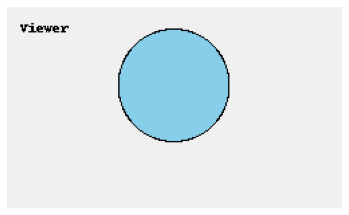

In [ ]:
#@title  { run: "auto" }
my_color = Color.BLUE #@param ["Color.BLUE", "Color.RED", "Color.GREEN"] {type:"raw"}
my_shape = ShapeType.CIRCLE #@param ["ShapeType.TRIANGLE", "ShapeType.SQUARE", "ShapeType.CIRCLE"] {type:"raw"}
my_size = Size.LARGE #@param ["Size.SMALL", "Size.MEDIUM", "Size.LARGE"] {type:"raw"}

my_viewer = Entity(properties = {
    Color:my_color,
    Size:my_size,
    ShapeType:my_shape,
})

# Display with a ShapeFetcher.
ShapeFetcher([my_viewer], 'Viewer').fetch()

Now, let's say we're looking at some images of other shapes.

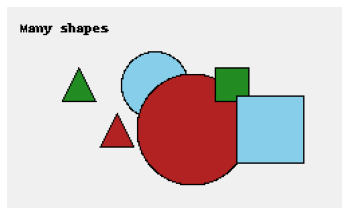

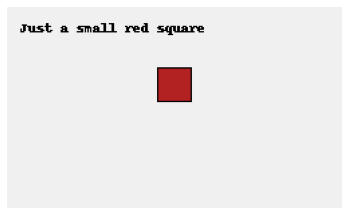

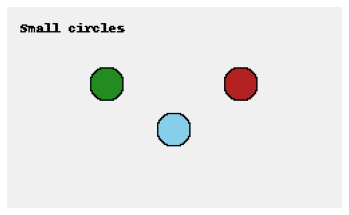

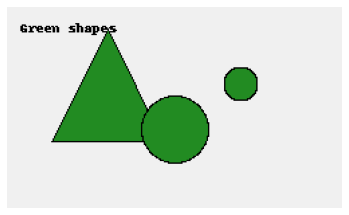

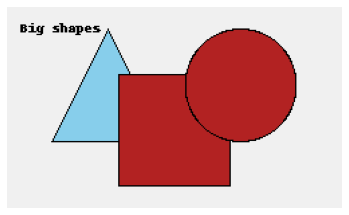

In [ ]:
#@title Some other shapes:


circles = create_image_from_shapes([
    Entity({
        Color: Color.GREEN,
        Size: Size.SMALL,
        ShapeType: ShapeType.CIRCLE
    }),
    Entity({
        Color: Color.BLUE,
        Size: Size.SMALL,
        ShapeType: ShapeType.CIRCLE
    }),
    Entity({
        Color: Color.RED,
        Size: Size.SMALL,
        ShapeType: ShapeType.CIRCLE
    })
], title='Small circles')

greens = create_image_from_shapes([
    Entity({
        Color: Color.GREEN,
        Size: Size.SMALL,
        ShapeType: ShapeType.CIRCLE
    }),
    Entity({
        Color: Color.GREEN,
        Size: Size.MEDIUM,
        ShapeType: ShapeType.CIRCLE
    }),
    Entity({
        Color: Color.GREEN,
        Size: Size.LARGE,
        ShapeType: ShapeType.TRIANGLE
    })
], title='Green shapes')

bigs = create_image_from_shapes([
    Entity({
        Size: Size.LARGE,
        Color: Color.RED,
        ShapeType: ShapeType.CIRCLE
    }),
    Entity({
        Size: Size.LARGE,
        Color: Color.RED,
        ShapeType: ShapeType.SQUARE
    }),
    Entity({
        Size: Size.LARGE,
        Color: Color.BLUE,
        ShapeType: ShapeType.TRIANGLE
    })
], title='Big shapes')

just_one = create_image_from_shapes([
    Entity({
        Size: Size.SMALL,
        Color: Color.RED,
        ShapeType: ShapeType.SQUARE
    }),
    
], title='Just a small red square')

diverse = create_image_from_shapes([
    Entity({
        Size: Size.LARGE,
        Color: Color.RED,
        ShapeType: ShapeType.CIRCLE
    }),
    Entity({
        Size: Size.MEDIUM,
        Color: Color.BLUE,
        ShapeType: ShapeType.SQUARE
    }),
    Entity({
        Size: Size.MEDIUM,
        Color: Color.BLUE,
        ShapeType: ShapeType.CIRCLE
    }),
    Entity({
        Size: Size.SMALL,
        Color: Color.RED,
        ShapeType: ShapeType.TRIANGLE
    }),
    Entity({
        Size: Size.SMALL,
        Color: Color.GREEN,
        ShapeType: ShapeType.TRIANGLE
    }),
    Entity({
        Size: Size.SMALL,
        Color: Color.GREEN,
        ShapeType: ShapeType.SQUARE
    })], title='Many shapes')

diverse.show()
just_one.show()
circles.show()
greens.show()
bigs.show()

Just looking at it, it seems like some of these groups are more **diverse** than others. Some contain all different sizes, shapes, and colors; some look mostly the same.

For example, the `Green shapes` image has a pretty low color diversity (they're all green), a medium amount of shape diversity (2 of the 3 shapes are represented), and lots of size diversity (all three sizes—small, medium, and large—are represented).

What happens if we try and quantify that?

Run the cell below to see one way of doing it:





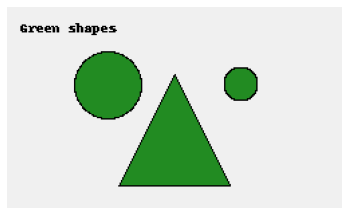


Diversity subscores (single image):

  - Aggregating scores across entities in image using method: average
  - Using counts or simple binary presence/absence? binary

   Which of the possible <enum 'Color'>s are present?
   --> <enum 'Color'> subscore: 0.333
           Color.RED: 0
           Color.BLUE: 0
           Color.GREEN: 3
           1 <enum 'Color'>s represented / 3 total categories
           average (binary vector): 0.333

   Which of the possible <enum 'Size'>s are present?
   --> <enum 'Size'> subscore: 1.0
           Size.MEDIUM: 1
           Size.SMALL: 1
           Size.LARGE: 1
           3 <enum 'Size'>s represented / 3 total categories
           average (binary vector): 1.0

   Which of the possible <enum 'ShapeType'>s are present?
   --> <enum 'ShapeType'> subscore: 0.667
           ShapeType.TRIANGLE: 1
           ShapeType.CIRCLE: 2
           ShapeType.SQUARE: 0
           2 <enum 'ShapeType'>s represented / 3 total categories
           average (binary vector

In [ ]:
#@title Try out a simple diversity scoring function:
simple_diversity = DiversityFn(
    aggregate_method='average', 
    count_or_binary='binary', 
    verbose_output=True)
greens.show()
subscores = simple_diversity.score_image(greens)
print()

We'll play around with those parameters more later.

Now, let's take the **viewer** into account. Looking at all of the groups of shapes, what would it mean for a group to be **inclusive** of shapes like you?

One way of thinking of it might be saying, "that group is inclusive because it has shapes that **look kind of like me**". 

In this framework, you might find a group inclusive even if there's no shape in the group that looks _exactly_ like you, as long as it contains shapes that have your same color, size, or shape.

Just like diversity, we can think of being inclusive with respect to different **attributes**.

Let's see one way of quantifying that:


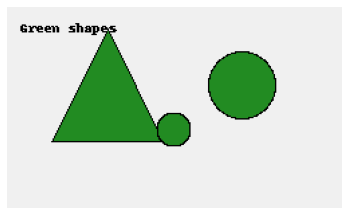


Inclusion subscores (single image)

  - Using aggregation method: max

   Does anyone have the same <enum 'Color'> as me? (BLUE)
   --> <enum 'Color'> match subscore: 0.0
       per-entity scores: ['entity_0 = 0.0', 'entity_1 = 0.0', 'entity_2 = 0.0']
        max: 0.0

   Does anyone have a similar <enum 'Size'> to mine? (LARGE)
   --> bucketed <enum 'Size'> closeness subscore: 1.0
       per-entity scores: ['entity_0 = 1.0', 'entity_1 = 0.0', 'entity_2 = 0.5']
       max: 1.0

   Does anyone have the same <enum 'ShapeType'> as me? (CIRCLE)
   --> <enum 'ShapeType'> match subscore: 1.0
       per-entity scores: ['entity_0 = 0.0', 'entity_1 = 1.0', 'entity_2 = 1.0']
        max: 1.0




In [ ]:
#@title Example inclusion score:
simple_inclusion = inclusion_fn = InclusionFn(
    # How to aggregate across *entities* in an image
    aggregate_method='max', 
    verbose_output=True)

greens.show()
simple_inclusion.score_image(my_viewer, greens)
print()

### Single image score

Suppose now you want to find a the group of shapes that's most **diverse** and **inclusive of you**. To compare all the different groups, you'll want to boil everything down to **one score** that summarizes everything. (So, a higher score will indicate the more diverse & inclusive group, and a lower score will indicate a less diverse & inclusive group.)

 To get just one score, you'll have to decide on a few things:
 
1.   How do you want to combine all of the different diversity and inclusion subscores for each group? For example, how important is shape diversity vs. color diversity vs. size diversity?
2.   How do you want to weigh diversity vs. inclusion overall?

There are lots of different options here, and they can all communicate different things. For example, if you chose to combine all of the diversity subscores by taking their minimum, it communicates that a group is only as diverse as its least-diverse quality.

Try some out!

In [ ]:
#@title How should diversity subscores be computed? { run: "auto" }
diversity_subscore_type = "weighted" #@param ["weighted", "egalitarian", "utilitarian", "nash", "min", "max", "average"]

In [ ]:
#@title If weighted, how much should we weight each subscore?

shape_weight = "some" #@param ["a lot", "some", "a little", "none"]
color_weight =  "a little" #@param ["a lot", "some", "a little", "none"]
size_weight =  "a lot" #@param ["a lot", "some", "a little", "none"]


_to_weight = {
    'a lot' : 1.0,
    'some' : 0.5,
    'a little' : 0.25,
    'none' : 0.0
}

def parse_normalize_weights(weight_str_list):
  total_value = 0
  output_weights = []
  for weight_str in weight_str_list:
    output_weights.append(_to_weight[weight_str])
  
  return [np.around(weight/sum(output_weights), 3) for weight in output_weights]

(shape_weight_value, 
 color_weight_value, 
 size_weight_value) = parse_normalize_weights([shape_weight, color_weight,  size_weight])
  
print('Normalized weights:\n  shape: %s\n'
'  color: %s\n'
'  size: %s\n' % (shape_weight_value, 
 color_weight_value, 
 size_weight_value))


print('Defined diversity scoring function')

# If we're weighting different components differently, aggregate_method
# expects a dictionary mapping attributes to weights. Otherwise, it will look up
# the appropriate aggregation method using its name (e.g. 'nash').
diversity_subscorer = None
if diversity_subscore_type == 'weighted':
  diversity_subscorer = {
      ShapeType : shape_weight_value,
      Color : color_weight_value,
      Size : size_weight_value
  }
else:
  diversity_subscorer = diversity_subscore_type

diversity_function = DiversityFn(
    aggregate_method=diversity_subscorer, 
    verbose_output=True)


Normalized weights:
  shape: 0.286
  color: 0.143
  size: 0.571

Defined diversity scoring function


In [ ]:
#@title Set some scoring parameters! { run: "auto" }
DIVERSITY_WEIGHT = 0.5 #@param {type:"slider", min:0, max:1, step:0.05}

DIVERSITY_AGGREGATE_ACROSS_ENTITIES = "average"
INCLUSION_AGGREGATE_ACROSS_ENTITIES = "max"
DIVERSITY_AGGREGATE_SUBSCORES = "min" #@param ["egalitarian", "utilitarian", "nash", "min", "max", "average"]
INCLUSION_AGGREGATE_SUBSCORES = "nash" #@param ["egalitarian", "utilitarian", "nash", "min", "max", "average"]

shape_scorer = Scorer(my_viewer)

shape_scorer.diversity_fn = DiversityFn(
    # How to aggregate across entities in an image
    aggregate_method=DIVERSITY_AGGREGATE_ACROSS_ENTITIES, 
    verbose_output=True)
shape_scorer.inclusion_fn = InclusionFn(
    # How to aggregate across entities in an image
    aggregate_method=INCLUSION_AGGREGATE_ACROSS_ENTITIES, 
    verbose_output=True)

combiner = Combiner(diversity_weight=DIVERSITY_WEIGHT, 
                    diversity_aggregate=DIVERSITY_AGGREGATE_SUBSCORES, 
                    inclusion_aggregate=INCLUSION_AGGREGATE_SUBSCORES)




shape_scorer.combiner = combiner 

print('Weighting diversity score at %s, inclusion score at %s\n' % (
    combiner.diversity_weight, combiner.inclusion_weight))
print('Using %s to aggregate inclusion subscores across entities in an image.' % combiner.inclusion_aggregate_name)
print('Using %s to aggregate diversity subscores across entities in an image.' % combiner.diversity_aggregate_name)
print('Using %s to aggregate different types of diversity scores for each entity.' % shape_scorer.diversity_fn.aggregate_method)
print('Using %s to aggregate different types of inclusion scores for each entity.' % shape_scorer.inclusion_fn.aggregate_method)



Weighting diversity score at 0.5, inclusion score at 0.5

Using nash to aggregate inclusion subscores across entities in an image.
Using min to aggregate diversity subscores across entities in an image.
Using average to aggregate different types of diversity scores for each entity.
Using max to aggregate different types of inclusion scores for each entity.


Let's try out this metric on some images!


===== Scoring =====



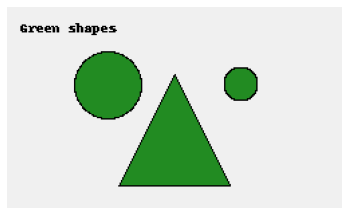

<enum 'Color'>: Color.BLUE <enum 'Size'>: Size.LARGE <enum 'ShapeType'>: ShapeType.CIRCLE

Diversity subscores (single image):

  - Aggregating scores across entities in image using method: average
  - Using counts or simple binary presence/absence? binary

   Which of the possible <enum 'Color'>s are present?
   --> <enum 'Color'> subscore: 0.333
           Color.RED: 0
           Color.BLUE: 0
           Color.GREEN: 3
           1 <enum 'Color'>s represented / 3 total categories
           average (binary vector): 0.333

   Which of the possible <enum 'Size'>s are present?
   --> <enum 'Size'> subscore: 1.0
           Size.MEDIUM: 1
           Size.SMALL: 1
           Size.LARGE: 1
           3 <enum 'Size'>s represented / 3 total categories
           average (binary vector): 1.0

   Which of the possible <enum 'ShapeType'>s are present?
   --> <enum 'ShapeType'> subscore: 0.667
           ShapeType.TRIANGLE: 1
           ShapeType.CIRCLE: 2
           ShapeType.SQUARE: 0
         

0.16666666666666666

In [ ]:
shape_scorer.score_image(greens, verbose_output=True)


===== Scoring =====



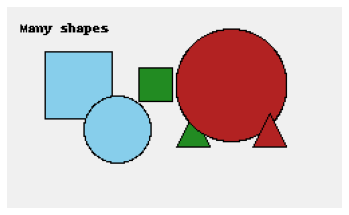

<enum 'Color'>: Color.BLUE <enum 'Size'>: Size.LARGE <enum 'ShapeType'>: ShapeType.CIRCLE

Diversity subscores (single image):

  - Aggregating scores across entities in image using method: average
  - Using counts or simple binary presence/absence? binary

   Which of the possible <enum 'Size'>s are present?
   --> <enum 'Size'> subscore: 1.0
           Size.MEDIUM: 2
           Size.SMALL: 3
           Size.LARGE: 1
           3 <enum 'Size'>s represented / 3 total categories
           average (binary vector): 1.0

   Which of the possible <enum 'Color'>s are present?
   --> <enum 'Color'> subscore: 1.0
           Color.RED: 2
           Color.BLUE: 2
           Color.GREEN: 2
           3 <enum 'Color'>s represented / 3 total categories
           average (binary vector): 1.0

   Which of the possible <enum 'ShapeType'>s are present?
   --> <enum 'ShapeType'> subscore: 1.0
           ShapeType.TRIANGLE: 2
           ShapeType.CIRCLE: 2
           ShapeType.SQUARE: 2
           3 <e

1.0

In [ ]:
shape_scorer.score_image(diverse, verbose_output=True)

Using these net scores, we can also rank our images!



===== Ranking =====
<enum 'Color'>: Color.BLUE <enum 'Size'>: Size.LARGE <enum 'ShapeType'>: ShapeType.CIRCLE
Query: 


==== Ranking 1 [score: 1.0] ====


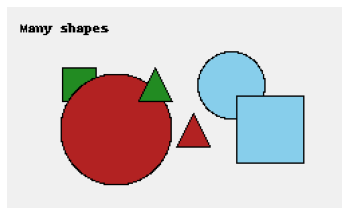



==== Ranking 2 [score: 0.667] ====


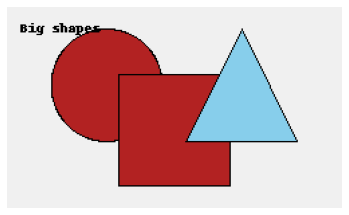



==== Ranking 3 [score: 0.167] ====


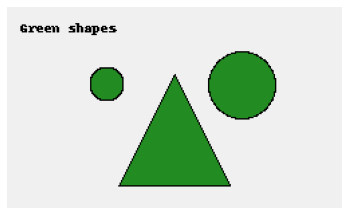



==== Ranking 4 [score: 0.167] ====


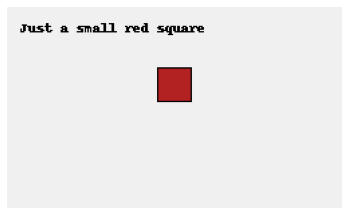



==== Ranking 5 [score: 0.167] ====


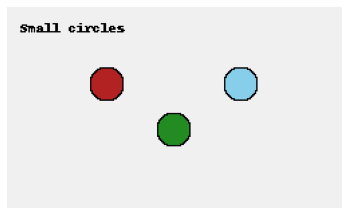

In [ ]:
ranking = shape_scorer.rank_images(images=[greens, diverse, just_one, circles, bigs], 
                                   verbose_output=True)

## Part II: People

When we think about diversity and inclusion, we're often thinking about **social, personal, and cultural** layers as well. In a world of shapes and colors, the choice to prioritize diverse shapes over diverse colors is mostly arbitrary. But when thinking about diversifying images of people, **context matters**.

What are we using these images for? Is it selecting images for a college brochure? Discovering new hairstyles? Searching for medical advice?

What impact does an image set being "more diverse" or "more inclusive" have in this use case? Does representing many ages have the same impact of representing many gender presentations?



### Toy example: a few images

Supppose we're using the same ideas of inclusion and diversity as before, but now we're using it to rank images of people in an image retriever tool. 

We're going to keep things simple and evaluate diversity and inclusion with respect to a few coarse buckets: perceived **skin type\***, **age**, and **gender presentation**. 

*This is using the [Fitzpatrick skin type scale](https://en.wikipedia.org/wiki/Fitzpatrick_scale), a scale used in dermatology that roughly corresponds to skin darkness.


NOTE: **The images below have been tagged for demonstration purposes only; we don't have ground-truth labels for gender, skin tone, or age for these images.**

First, enter the demographic information for the image viewer:

In [ ]:
#@title Enter a viewer's demographics
age =  30#@param {type:"integer"}
skin_type = 2 #@param {type:"slider", min:1, max:6, step:1}
gender_presentation = "androgynous"  #@param ["masculine", "feminine", "androgynous"]

self_params = {
    Age:age_to_enum(age),
    SkinType:skin_type_to_enum(skin_type),
    GenderPresentation:gender_to_enum(gender_presentation),
}

# me = Person(properties=self_params)
me = Entity(self_params)
scorer = Scorer(me) # Scoring is dependent on the viewer
print(me)

<enum 'Age'>: Age.RANGE_25_44 <enum 'SkinType'>: SkinType.TYPE_2 <enum 'GenderPresentation'>: GenderPresentation.ANDROGYNOUS


In [ ]:
#@title Display our example images

test_url_1 = 'http://t0.gstatic.com/images?q=tbn:ANd9GcRvV0wp1mj3YUtZBsVlueDvUt0I0UbL9nIgBoPdTPnOSIZ4UCqEHP1UC5J26ULLAxazBvVv7BUNME0iO1QzimdKicZalaI'
test_url_2 = 'http://t1.gstatic.com/images?q=tbn:ANd9GcQrK6SD6AgFfZlJcdrHhcAzTQSpWmf87ZvAA8DsTOpzwg2SSiKk9VrmA5VhifqVbwt4SgP3B7cFdB8In6NKNs1Q7nAelpU'
test_url_3 = 'https://media.gettyimages.com/photos/picture-id973089468'

image_1_persons = [
    Entity({
        Age: age_to_enum(48),
        SkinType: skin_type_to_enum(4),
        GenderPresentation: gender_to_enum('masculine')
    })
]
image_1_params = {'subjects': ['doctor']}

image_2_persons = [
    Entity({
        Age: age_to_enum(33),
        SkinType: skin_type_to_enum(5),
        GenderPresentation: gender_to_enum('feminine')
    })
]
image_2_params = {'subjects': ['doctor', 'smiling']}

image_3_persons = [
    Entity({
        Age: age_to_enum(19),
        SkinType: skin_type_to_enum(1),
        GenderPresentation: gender_to_enum('feminine')
    }),
    Entity({
        Age: age_to_enum(23),
        SkinType: skin_type_to_enum(1),
        GenderPresentation: gender_to_enum('masculine')
    }),
    Entity({
        Age: age_to_enum(45),
        SkinType: skin_type_to_enum(2),
        GenderPresentation: gender_to_enum('feminine')
    })
]
image_3_params = {
    'subjects': ['computer_programmer', 'smiling']
}

image_1 = EntityImage(image_1_persons, PersonFetcher(test_url_1), image_1_params)
image_2 = EntityImage(image_2_persons, PersonFetcher(test_url_2), image_2_params)
image_3 = EntityImage(image_3_persons, PersonFetcher(test_url_3), image_3_params)


image_1.show()
image_2.show()
image_3.show()

Now we can set a bunch of parameters and see exactly how our net diversity and inclusion scores are calculated!

In [ ]:
#@title How much to weigh out overall diversity vs. inclusion score?
DIVERSITY_VS_INCLUSION_WEIGHT = 0.45 #@param {type:"slider", min:0, max:1, step:0.05}


In [ ]:
#@title How should we aggregate the diversity scores across all people in an image? { run: "auto" }
DIVERSITY_AGGREGATE_ACROSS_PEOPLE = "average" #@param ["egalitarian", "utilitarian", "nash", "min", "max", "average"]


In [ ]:
#@title How should we weigh the different components of our diversity scores? { run: "auto" }

DIVERSITY_AGE_WEIGHT = 0.1 #@param {type:"slider", min:0, max:1, step:0.05}
DIVERSITY_GENDER_PRESENTATION_WEIGHT = 0.4 #@param {type:"slider", min:0, max:1, step:0.05}
DIVERSITY_SKIN_TYPE_WEIGHT = 0.4 #@param {type:"slider", min:0, max:1, step:0.05}

DIVERSITY_AGGREGATE_SCORES = {Age : DIVERSITY_AGE_WEIGHT,
                              GenderPresentation : DIVERSITY_GENDER_PRESENTATION_WEIGHT,
                              SkinType : DIVERSITY_SKIN_TYPE_WEIGHT}

In [ ]:
#@title How should we aggregate the inclusion scores across all people in an image? { run: "auto" }
INCLUSION_AGGREGATE_ACROSS_PEOPLE = "average" #@param ["egalitarian", "utilitarian", "nash", "min", "max", "average"]


In [ ]:
#@title How should we weigh the different components of our inclusion scores? { run: "auto" }

INCLUSION_AGE_WEIGHT = 0.4 #@param {type:"slider", min:0, max:1, step:0.05}
INCLUSION_GENDER_PRESENTATION_WEIGHT = 0.1 #@param {type:"slider", min:0, max:1, step:0.05}
INCLUSION_SKIN_TYPE_WEIGHT = 0.85 #@param {type:"slider", min:0, max:1, step:0.05}

INCLUSION_AGGREGATE_SCORES = {Age : INCLUSION_AGE_WEIGHT,
                              GenderPresentation : INCLUSION_GENDER_PRESENTATION_WEIGHT,
                              SkinType : INCLUSION_SKIN_TYPE_WEIGHT}

In [ ]:
#@title Roll that all up into a scoring function...
# How to aggregate across different types of subscores (e.g. age vs. gender)
combiner = Combiner(diversity_weight=DIVERSITY_WEIGHT, 
                    diversity_aggregate=DIVERSITY_AGGREGATE_SCORES, 
                    inclusion_aggregate=INCLUSION_AGGREGATE_SCORES)

scorer.diversity_fn = DiversityFn(
    # How to aggregate across *people* in an image
    aggregate_method=DIVERSITY_AGGREGATE_ACROSS_PEOPLE, 
    verbose_output=True)
scorer.inclusion_fn = InclusionFn(
    # How to aggregate across *people* in an image
    aggregate_method=INCLUSION_AGGREGATE_ACROSS_PEOPLE, 
    verbose_output=True)
scorer.combiner = combiner

print('Weighting diversity score at %s, inclusion score at %s' % (
    combiner.diversity_weight, combiner.inclusion_weight))
print()
print('Using %s to aggregate across individuals in each image (to get each inclusion subscore).' % scorer.inclusion_fn.aggregate_method)
print('Using %s to aggregate across individuals in each image (to get each diversity subscore).' % scorer.diversity_fn.aggregate_method)
print('Using %s to aggregate inclusion subscores.' % combiner.inclusion_aggregate_name)
print('Using %s to aggregate diversity subscores.' % combiner.diversity_aggregate_name )
print()
print('Viewer:', me)
# print('Query:', query)


Weighting diversity score at 0.5, inclusion score at 0.5

Using average to aggregate across individuals in each image (to get each inclusion subscore).
Using average to aggregate across individuals in each image (to get each diversity subscore).
Using weighed_average to aggregate inclusion subscores.
Using weighed_average to aggregate diversity subscores.

Viewer: <enum 'Age'>: Age.RANGE_25_44 <enum 'SkinType'>: SkinType.TYPE_2 <enum 'GenderPresentation'>: GenderPresentation.ANDROGYNOUS


Voila! Now we can see what our function outputs:

In [ ]:
#@title Example: score an image with one person
individ_score = scorer.score_image(image_1,
                                   verbose_output=True)


===== Scoring =====



<enum 'Age'>: Age.RANGE_25_44 <enum 'SkinType'>: SkinType.TYPE_2 <enum 'GenderPresentation'>: GenderPresentation.ANDROGYNOUS

Diversity subscores (single image):

  - Aggregating scores across entities in image using method: average
  - Using counts or simple binary presence/absence? binary

   Which of the possible <enum 'Age'>s are present?
   --> <enum 'Age'> subscore: 0.167
           Age.RANGE_45_64: 1
           Age.RANGE_0_17: 0
           Age.UNKNOWN: 0
           Age.RANGE_25_44: 0
           Age.RANGE_18_24: 0
           Age.RANGE_65_OVER: 0
           1 <enum 'Age'>s represented / 6 total categories
           average (binary vector): 0.167

   Which of the possible <enum 'SkinType'>s are present?
   --> <enum 'SkinType'> subscore: 0.143
           SkinType.TYPE_3: 0
           SkinType.TYPE_1: 0
           SkinType.TYPE_4: 1
           SkinType.TYPE_6: 0
           SkinType.UNKNOWN: 0
           SkinType.TYPE_2: 0
           SkinType.TYPE_5: 0
           1 <enum 'SkinType'>

In [ ]:
#@title Example: Score an image with a small group
scorer.diversity_fn = DiversityFn(aggregate_method='average', verbose_output=True)
scorer.inclusion_fn = InclusionFn(aggregate_method='max', verbose_output=True)
scorer.combiner = combiner
individ_score = scorer.score_image(image_3, 
                                  #  query,
                                   verbose_output=True)


===== Scoring =====



<enum 'Age'>: Age.RANGE_25_44 <enum 'SkinType'>: SkinType.TYPE_2 <enum 'GenderPresentation'>: GenderPresentation.ANDROGYNOUS

Diversity subscores (single image):

  - Aggregating scores across entities in image using method: average
  - Using counts or simple binary presence/absence? binary

   Which of the possible <enum 'Age'>s are present?
   --> <enum 'Age'> subscore: 0.333
           Age.RANGE_45_64: 1
           Age.RANGE_0_17: 0
           Age.UNKNOWN: 0
           Age.RANGE_25_44: 0
           Age.RANGE_18_24: 2
           Age.RANGE_65_OVER: 0
           2 <enum 'Age'>s represented / 6 total categories
           average (binary vector): 0.333

   Which of the possible <enum 'SkinType'>s are present?
   --> <enum 'SkinType'> subscore: 0.286
           SkinType.TYPE_3: 0
           SkinType.TYPE_1: 2
           SkinType.TYPE_4: 0
           SkinType.TYPE_6: 0
           SkinType.UNKNOWN: 0
           SkinType.TYPE_2: 1
           SkinType.TYPE_5: 0
           2 <enum 'SkinType'>

In [ ]:
#@title Ranking images
image_ranking = scorer.rank_images(images=[image_1, image_2, image_3],
                                   verbose_output=True)

===== Ranking =====
<enum 'Age'>: Age.RANGE_25_44 <enum 'SkinType'>: SkinType.TYPE_2 <enum 'GenderPresentation'>: GenderPresentation.ANDROGYNOUS
Query: 


==== Ranking 1 [score: 0.759] ====




==== Ranking 2 [score: 0.53] ====




==== Ranking 3 [score: 0.499] ====


In [ ]:
#@title Example: treat our images as a set and aggregate all of the diversity and inclusion scores
scorer.score_set(images=[image_1, image_2, image_3],
                 verbose_output=True)


Scoring image 1


===== Scoring =====



<enum 'Age'>: Age.RANGE_25_44 <enum 'SkinType'>: SkinType.TYPE_2 <enum 'GenderPresentation'>: GenderPresentation.ANDROGYNOUS

Diversity subscores (single image):

  - Aggregating scores across entities in image using method: average
  - Using counts or simple binary presence/absence? binary

   Which of the possible <enum 'Age'>s are present?
   --> <enum 'Age'> subscore: 0.167
           Age.RANGE_45_64: 1
           Age.RANGE_0_17: 0
           Age.UNKNOWN: 0
           Age.RANGE_25_44: 0
           Age.RANGE_18_24: 0
           Age.RANGE_65_OVER: 0
           1 <enum 'Age'>s represented / 6 total categories
           average (binary vector): 0.167

   Which of the possible <enum 'SkinType'>s are present?
   --> <enum 'SkinType'> subscore: 0.143
           SkinType.TYPE_3: 0
           SkinType.TYPE_1: 0
           SkinType.TYPE_4: 1
           SkinType.TYPE_6: 0
           SkinType.UNKNOWN: 0
           SkinType.TYPE_2: 0
           SkinType.TYPE_5: 0
           1 <enum 'SkinType'>

<enum 'Age'>: Age.RANGE_25_44 <enum 'SkinType'>: SkinType.TYPE_2 <enum 'GenderPresentation'>: GenderPresentation.ANDROGYNOUS

Diversity subscores (single image):

  - Aggregating scores across entities in image using method: average
  - Using counts or simple binary presence/absence? binary

   Which of the possible <enum 'Age'>s are present?
   --> <enum 'Age'> subscore: 0.167
           Age.RANGE_45_64: 0
           Age.RANGE_0_17: 0
           Age.UNKNOWN: 0
           Age.RANGE_25_44: 1
           Age.RANGE_18_24: 0
           Age.RANGE_65_OVER: 0
           1 <enum 'Age'>s represented / 6 total categories
           average (binary vector): 0.167

   Which of the possible <enum 'SkinType'>s are present?
   --> <enum 'SkinType'> subscore: 0.143
           SkinType.TYPE_3: 0
           SkinType.TYPE_1: 0
           SkinType.TYPE_4: 0
           SkinType.TYPE_6: 0
           SkinType.UNKNOWN: 0
           SkinType.TYPE_2: 0
           SkinType.TYPE_5: 1
           1 <enum 'SkinType'>

<enum 'Age'>: Age.RANGE_25_44 <enum 'SkinType'>: SkinType.TYPE_2 <enum 'GenderPresentation'>: GenderPresentation.ANDROGYNOUS

Diversity subscores (single image):

  - Aggregating scores across entities in image using method: average
  - Using counts or simple binary presence/absence? binary

   Which of the possible <enum 'Age'>s are present?
   --> <enum 'Age'> subscore: 0.333
           Age.RANGE_45_64: 1
           Age.RANGE_0_17: 0
           Age.UNKNOWN: 0
           Age.RANGE_25_44: 0
           Age.RANGE_18_24: 2
           Age.RANGE_65_OVER: 0
           2 <enum 'Age'>s represented / 6 total categories
           average (binary vector): 0.333

   Which of the possible <enum 'SkinType'>s are present?
   --> <enum 'SkinType'> subscore: 0.286
           SkinType.TYPE_3: 0
           SkinType.TYPE_1: 2
           SkinType.TYPE_4: 0
           SkinType.TYPE_6: 0
           SkinType.UNKNOWN: 0
           SkinType.TYPE_2: 1
           SkinType.TYPE_5: 0
           2 <enum 'SkinType'>

0.5961507936507937

# Conclusion

As you can see in our toy examples, things can get complex fast, and it's easy to get lost in the details. What categories do we care about the most? How do we label them? What do these scores even mean? There's no obvious "right" way to design a ranking system like this. 

What's important to keep in mind is that when trying to quantify concepts like "diversity" and "inclusion" is this: even design decisions that seem arbitrary or inconsequential can end up encoding priorities, values, and worldviews. These details matter; be thoughtful!





# Credits

This notebook was written by Dylan Baker (`dylanbaker@google.com`).

Many thanks to Adam Pearce, Ellen Jiang, Meg Mitchell, Timnit Gebru, and Ben Hutchinson for their help and feedback.